In [ ]:
!wget https://www.manythings.org/anki/rus-eng.zip
!unzip rus-eng.zip

--2022-04-20 08:14:34--  https://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.92.44, 172.67.186.54, 2606:4700:3030::6815:5c2c, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.92.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14683939 (14M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  14.00M  --.-KB/s    in 0.1s    

2022-04-20 08:14:35 (93.4 MB/s) - ‘rus-eng.zip’ saved [14683939/14683939]

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Progbar

if torch.cuda.is_available():
  dev = "cuda"
else:
  dev = 'cpu'

device = torch.device(dev)

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



Опредим класс, который отвечает за словарь языка.

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.word2index = {"SOS":0, "EOS": 1}
        self.n_words = 2  

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Подготовим функции предобработки данных и чтения. 

In [ ]:
def normalizeString(s):
    s = s.lower()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яйёьъА-Яй]+", r" ", s)
    s = s.strip()
    return s

In [ ]:
def readLangs(filename, lang1, lang2, reverse=False):
    pairs_array = []
    lines = open(filename, encoding='utf-8').read().strip().split('\n')

    for line in lines:
      pair = list(map(normalizeString, line.split('\t')[:2]))
      pairs_array.append(pair)

    if reverse:
        pairs_array = [list(reversed(p)) for p in pairs_array]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs_array

input_lang, output_lang, pairs = readLangs('rus.txt', 'en', 'ru', True)
input_lang.name, output_lang.name, pairs[:5]

('ru',
 'en',
 [['марш', 'go'],
  ['иди', 'go'],
  ['идите', 'go'],
  ['здравствуйте', 'hi'],
  ['привет', 'hi']])

Отфильтруем наш датасет, чтобы остались только предложения, которые начинаются на строки из списка. Так мы сможем быстрее увидеть способность модели обучаться. 

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filter_pairs(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)

def prepareData(input_lang, output_lang, pairs):
    print("Read %s sentence pairs" % len(pairs))
    reduced_pairs = list(filter(filter_pairs, pairs))
    print("Trimmed to %s sentence pairs" % len(reduced_pairs))
    print("Counting words...")
    for pair in reduced_pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    random.shuffle(reduced_pairs)
    return input_lang, output_lang, reduced_pairs

input_lang, output_lang, reduced_pairs = prepareData(input_lang, output_lang, pairs)
print(random.choice(reduced_pairs))

Read 440219 sentence pairs
Trimmed to 27491 sentence pairs
Counting words...
Counted words:
ru 10070
en 4176
['ты можешь говорить с кем хочешь', 'you are free to talk with anyone']


Каждая будет представлено в формате кортежа, где первый элемент - вектор индексов русского языка, второй - английского. Каждый вектор в размера - (длина предложения, индекс слова(из словаря класса для языка)) . Для батчевого обучения, нам надо будет сделать каждое предложение одинаковой длины. 

In [ ]:
def pad(x, length=None):
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'EOS')

def indexesFromSentence(lang, sentence):
    return [lang.word2index['SOS']] + [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence, max_len):
    indexes = pad(indexesFromSentence(lang, sentence), max_len)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1,1)

def pad(x, length):
    if len(x) < length:
      x += [EOS_token] * (length - len(x))
    return x

def tensorsFromPair(pair, max_len):
    input_tensor = tensorFromSentence(input_lang, pair[0], max_len)
    target_tensor = tensorFromSentence(output_lang, pair[1], max_len)
    return (input_tensor, target_tensor)

def test():
  random_pair = random.choice(reduced_pairs)
  print(random_pair)
  print(tensorsFromPair(random_pair, MAX_LENGTH))

test()

['ценой я доволен', 'i m happy with the price']
(tensor([[   0],
        [5779],
        [  10],
        [ 213],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1]]), tensor([[   0],
        [   2],
        [   3],
        [ 100],
        [ 511],
        [ 325],
        [2606],
        [   1],
        [   1],
        [   1]]))


Для батчевого обучения сделаем классы Dataset и DataLoader. Каждый батч размерности - (количество батчей, длина предложения, индекс слова).

In [ ]:
class MTDataset(Dataset):
  def __init__(self, training_pairs, max_sent_len = 10):
    self.training_pairs = training_pairs
    self.max_sent_len = max_sent_len

  def __len__(self):
    return len(self.training_pairs)

  def __getitem__(self, idx):
    pair = self.training_pairs[idx]
    tensor_pair = tensorsFromPair(pair, MAX_LENGTH)
    return tensor_pair


def test__MTDataset():
  BATCH_SIZE = 2
  mt_dataset = MTDataset(reduced_pairs)
  mt_dataloder = DataLoader(mt_dataset, batch_size=BATCH_SIZE, drop_last=True)

  for batch in mt_dataloder:
    x = batch
  return x[0], x[1]

test__MTDataset()

(tensor([[[   0],
          [ 289],
          [ 293],
          [ 149],
          [   1],
          [   1],
          [   1],
          [   1],
          [   1],
          [   1]],
 
         [[   0],
          [  43],
          [ 277],
          [1184],
          [1091],
          [6663],
          [   1],
          [   1],
          [   1],
          [   1]]]), tensor([[[   0],
          [ 131],
          [  68],
          [  22],
          [ 133],
          [ 388],
          [   1],
          [   1],
          [   1],
          [   1]],
 
         [[   0],
          [  19],
          [  20],
          [ 128],
          [ 105],
          [1146],
          [2526],
          [   1],
          [   1],
          [   1]]]))

### Моделирование


Определим классы энкодера, декодера и процесса обучения. Протестируем каждый метод. 

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden, batch_size):
        #вход в pytorch в RNN моделях - (длина элемента на вход на текущем шаге, размер батча, размер скрытого слоя) - поэтому сделаем reshape
        # https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
        embedded = self.embedding(input).reshape(1, batch_size,  self.hidden_size)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)


def test_encoder():
  BATCH_SIZE = 2

  mt_dataset = MTDataset(reduced_pairs)
  mt_dataloder = DataLoader(mt_dataset, batch_size=BATCH_SIZE, drop_last=True)

  TEST_BATCH = list(mt_dataloder)[0]
  MAX_LENGTH = 10
  HIDDEN_SIZE = 15
  encoder = EncoderRNN(input_lang.n_words, HIDDEN_SIZE).to(device)
  # для каждого элемента батча - свой hidden state
  encoder_hidden = encoder.initHidden(BATCH_SIZE)
  input_tensor, target_tensor = TEST_BATCH[0], TEST_BATCH[1]
  input_length = input_tensor.shape[1]
  for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(input_tensor[:, ei, :], encoder_hidden, BATCH_SIZE)


  assert encoder_output.shape == torch.Size([1, BATCH_SIZE, 15])

test_encoder()

Аналогично с декордером. 

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, hidden, batch_size):
        output = self.embedding(input).reshape(1, batch_size,  self.hidden_size)
        output, hidden = self.gru(output, hidden)
        linear_proj = self.out(output)
        output = self.softmax(linear_proj)
        return output, hidden


def test_decoder():
  BATCH_SIZE = 2

  mt_dataset = MTDataset(reduced_pairs)
  mt_dataloder = DataLoader(mt_dataset, batch_size=BATCH_SIZE, drop_last=True)

  TEST_BATCH = list(mt_dataloder)[0]
  MAX_LENGTH = 10
  HIDDEN_SIZE = 15
  decoder = DecoderRNN(HIDDEN_SIZE, output_lang.n_words).to(device)

  input_tensor, target_tensor = TEST_BATCH[0], TEST_BATCH[1]
  decoder_input = torch.tensor([[SOS_token] * BATCH_SIZE],dtype=torch.long, device=device).view(1, BATCH_SIZE, 1)
  decoder_hidden = torch.rand(1, BATCH_SIZE, HIDDEN_SIZE).to(device)#encoder_hidden

  target_length = target_tensor.shape[1]
  for di in range(target_length):
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, BATCH_SIZE)
    topv, topi = decoder_output.topk(1)
    decoder_input = topi.reshape(1, BATCH_SIZE, 1)
  #проверим что в результате у нас выход из декодера - (размер батча, распределние по vocab) - должен получится массив размера количетсво примеров в батче из 1. 
  print((np.exp(1) ** decoder_output.detach().cpu().numpy()).sum(2))
  print(decoder_input)

test_decoder()

[[0.9999999 1.0000006]]
tensor([[[2489],
         [1306]]])


In [ ]:
def train_on_batch(input_tensor, target_tensor, encoder, decoder, 
                    encoder_optimizer, decoder_optimizer, criterion, 
                    batch_size, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden(batch_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    HIDDEN_SIZE = 15

    input_length = input_tensor.shape[1]
    for ei in range(input_length):
      encoder_output, encoder_hidden = encoder(input_tensor[:, ei, :], encoder_hidden, batch_size)
    
    decoder_input = torch.tensor([[SOS_token] * batch_size],dtype=torch.long, device=device).view(1, batch_size, 1)
    decoder_hidden = encoder_hidden

    target_length = target_tensor.shape[1]
    loss = 0
    for di in range(target_length):
      decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, batch_size)
      topv, topi = decoder_output.topk(1)
      decoder_input = topi.reshape(1, batch_size, 1)
      #на вход функции ошибки - распределение выхода, верные индексы на данном этапе. 
      loss += criterion(decoder_output.squeeze(), target_tensor[:, di, :].squeeze())

    loss = loss / batch_size
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()

def test__train_on_batch():
  BATCH_SIZE = 2

  mt_dataset = MTDataset(reduced_pairs)
  mt_dataloder = DataLoader(mt_dataset, batch_size=BATCH_SIZE, drop_last=True)

  TEST_BATCH = list(mt_dataloder)[0]

  HIDDEN_SIZE = 15
  LEARNING_RATE = 1e-3
  encoder = EncoderRNN(input_lang.n_words, HIDDEN_SIZE).to(device)
  decoder = DecoderRNN(HIDDEN_SIZE, output_lang.n_words).to(device)

  encoder_optimizer = optim.Adam(encoder.parameters(), lr=LEARNING_RATE)
  decoder_optimizer = optim.Adam(decoder.parameters(), lr=LEARNING_RATE)

  input_tensor, target_tensor = TEST_BATCH[0].view(BATCH_SIZE, MAX_LENGTH, 1), TEST_BATCH[1].view(BATCH_SIZE, MAX_LENGTH, 1)

  criterion = nn.NLLLoss()

  loss = train_on_batch(input_tensor, target_tensor, encoder, decoder, 
                        encoder_optimizer, decoder_optimizer, criterion, 
                        BATCH_SIZE)
  return loss

test__train_on_batch()

43.15223693847656

In [ ]:
def evaluate_sample(encoder, decoder, sentence):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence, MAX_LENGTH).view(1, MAX_LENGTH, 1)
        input_length = input_tensor.size()[1]
        encoder_hidden = encoder.initHidden(1)

        for ei in range(input_length):
          encoder_output, encoder_hidden = encoder(input_tensor[:, ei, :],
                                                     encoder_hidden, 1)

        decoder_input = torch.tensor([[SOS_token] * 1],dtype=torch.long, device=device).view(1, 1, 1)
        decoder_hidden = encoder_hidden
        decoded_words = []

        for di in range(MAX_LENGTH):
          decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, 1)
          topv, topi = decoder_output.data.topk(1)
          decoder_input = topi.reshape(1, 1, 1)
          decoded_words.append(output_lang.index2word[topi.item()])
    return decoded_words


def test__evaluate_sample():
  HIDDEN_SIZE = 15
  encoder = EncoderRNN(input_lang.n_words, HIDDEN_SIZE).to(device)
  decoder = DecoderRNN(HIDDEN_SIZE, output_lang.n_words).to(device)

  sentence = 'я иду домой'
  pred = evaluate_sample(encoder, decoder, sentence)
  return pred

test__evaluate_sample()

['mood',
 'broom',
 'clear',
 'clear',
 'defenseless',
 'cocaine',
 'defenseless',
 'defenseless',
 'defenseless',
 'defenseless']

In [ ]:
from torchtext.data.metrics import bleu_score
# from tqdm import tqdm_notebook


candidate_corpus_v1 = [['My', 'full', 'pytorch', 'test'], ['Another', 'Sentence']]
references_corpus_v1 = [[['My', 'full', 'pytorch', 'test'], ['test','text']], [['No', 'Match']]]

candidate_corpus_v2 = [['My', 'full', 'pytorch', 'test']]
references_corpus_v2 = [[['My', 'full', 'pytorch', 'test']]]

print('Example BLEU score: ', bleu_score(candidate_corpus_v1, references_corpus_v1))
print('Example BLEU score: ', bleu_score(candidate_corpus_v2, references_corpus_v2))

Example BLEU score:  0.8408964276313782
Example BLEU score:  1.0


In [ ]:
def sentenceFromTesor(batch):
    batch_size = batch[0].shape[0]
    input_batch = batch[0].cpu().numpy().reshape(batch_size, MAX_LENGTH)
    target_batch = batch[1].cpu().numpy().reshape(batch_size, MAX_LENGTH)
    print(input_batch)
    input_list = []
    for idx_list in input_batch:
      sent = [input_lang.index2word[idx] for idx in idx_list]
      sent = list(filter(lambda x: x != 'SOS' and x != 'EOS', sent))
      input_list.append(sent)

    target_list = []
    for idx_list in target_batch:
      sent = [output_lang.index2word[idx] for idx in idx_list]
      sent = list(filter(lambda x: x != 'SOS' and x != 'EOS', sent))
      target_list.append(sent)
    return input_list, target_list

def test__sentenceFromTesor():
  BATCH_SIZE = 2

  mt_dataset = MTDataset(reduced_pairs)
  mt_dataloder = DataLoader(mt_dataset, batch_size=BATCH_SIZE, drop_last=True)

  TEST_BATCH = list(mt_dataloder)[0]
  print(sentenceFromTesor(TEST_BATCH))

### Evaluate on batch sample

Для проверки работы нашей модели обучимся на 1 батче до полного совпадения по BLEU и ошибки равной нулю.

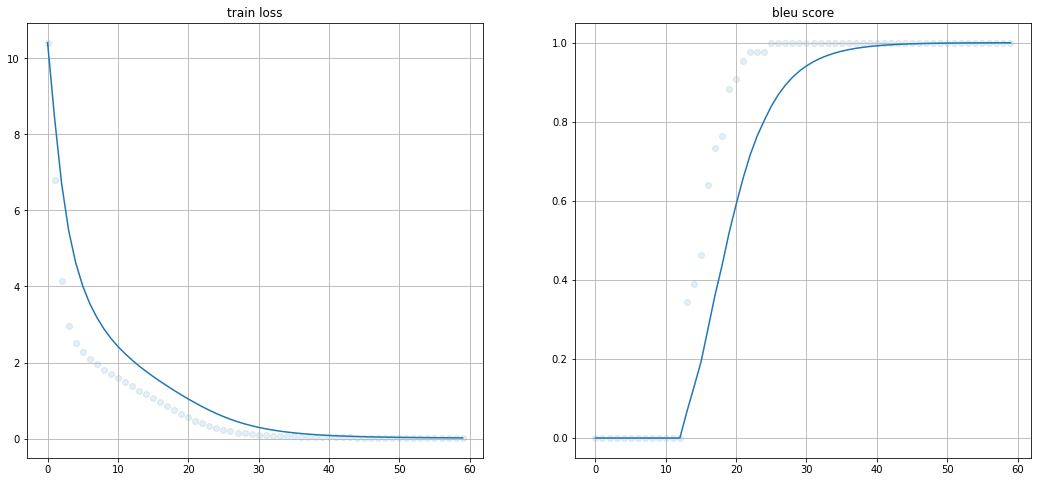

< мы неудачники
= we re losers
= we re losers

< мы не собираемся сдаваться
= we re not going to give up
= we re not going to give up

< ты наблюдательная
= you re observant
= you re observant

< я на это рассчитываю
= i m counting on it
= i m counting on it

< я уверен что том не умеет плавать
= i m sure tom can t swim
= i m sure tom can t swim

< мне понадобится еще немного времени
= i m going to need some more time
= i m going to need some more time

< мы празднуем юбилей
= we re celebrating our anniversary
= we re celebrating our anniversary

< я уверен что кто нибудь это сделает
= i m sure someone will do it
= i m sure someone will do it



In [ ]:
EPOCH_NUM = 300
LEARNING_RATE = 1e-3
SHOW_EVERY = 5
BATCH_SIZE = 8

mt_dataset = MTDataset(reduced_pairs)
mt_dataloder = DataLoader(mt_dataset, batch_size=BATCH_SIZE, drop_last=True)

TEST_BATCH = list(mt_dataloder)[0]

debug_f = open('debug_progress_log.txt', 'w')

input_tensor, target_tensor = TEST_BATCH[0].view(BATCH_SIZE, MAX_LENGTH, 1), TEST_BATCH[1].view(BATCH_SIZE, MAX_LENGTH, 1)
input_sentences, target_sentences = sentenceFromTesor(TEST_BATCH)

ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values

hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

encoder_optimizer = optim.Adam(encoder.parameters(), lr=LEARNING_RATE)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=LEARNING_RATE)

criterion = nn.NLLLoss()
loss_array = []
bleu_array = []

for epoch in range(EPOCH_NUM):
  loss = train_on_batch(input_tensor, target_tensor, encoder, decoder, 
                        encoder_optimizer, decoder_optimizer, criterion,
                        batch_size=BATCH_SIZE)

  if epoch % SHOW_EVERY == 0:
    loss_array.append(loss)
    translated_list = []

    for sentence in input_sentences:
      input_sent = " ".join(sentence)
      translated_sentence = evaluate_sample(encoder, decoder, input_sent)
      translated_sentence = list(filter(lambda x: x!= 'EOS' and x != 'SOS', translated_sentence))
      translated_list.append(translated_sentence)
  
    with open('debug_progress_log.txt', 'a') as f:
      debug_f.write(f'Epoch = {epoch}, current loss = {loss_array[-1]}\n')
      debug_f.write(f'>{" ".join(input_sentences[-1])}\n')
      debug_f.write(f'={" ".join(target_sentences[-1])}\n')
      debug_f.write(f'<{" ".join(translated_list[-1])}\n')
      debug_f.write('####################\n')

    ref_sentences = [[ref] for ref in target_sentences]
    score = bleu_score(translated_list, ref_sentences)
    bleu_array.append(score)

    clear_output(True)
    plt.figure(figsize=[18, 8])
    plt.subplot(1, 2, 1), plt.title('train loss'), plt.grid()
    plt.scatter(np.arange(len(loss_array)), loss_array, alpha=0.12)
    plt.plot(ewma(loss_array, span=10))

    plt.subplot(1, 2, 2), plt.title('bleu score'), plt.grid()
    plt.scatter(np.arange(len(bleu_array)), bleu_array, alpha=0.12)
    plt.plot(ewma(bleu_array, span=10))
    plt.show()


for true, target, translated in zip(input_sentences, target_sentences, translated_list):
  print('<', " ".join(true))
  print('=', " ".join(target))
  print('=', " ".join(translated))
  print()

### Train on full set

Теперь обучимся на полном сете. 

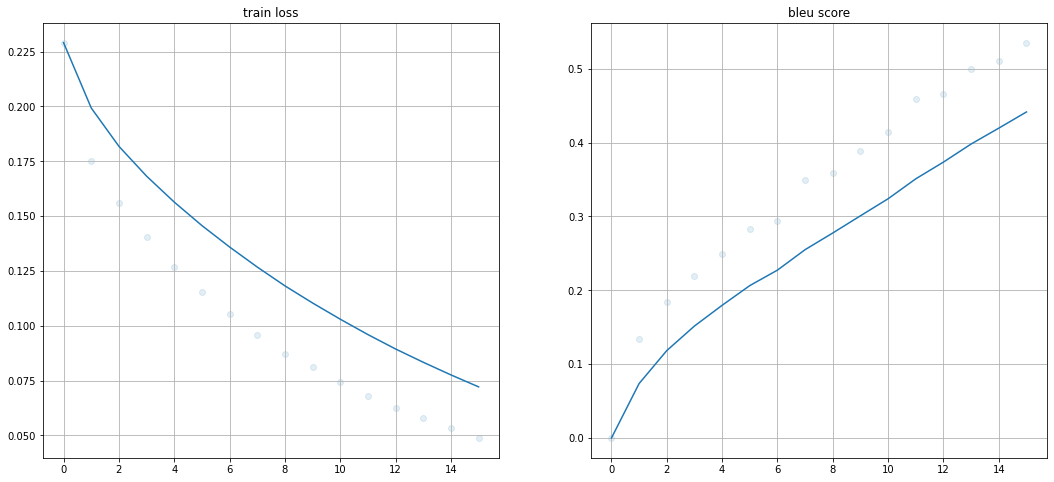

 30/214 [===>..........................] - ETA: 1:33

KeyboardInterrupt: ignored

In [ ]:
EPOCH_NUM = 50
LEARNING_RATE = 1e-3
SHOW_EVERY = 1
BATCH_SIZE = 128


f = open('progress_log.txt', 'w')

mt_dataset = MTDataset(reduced_pairs)
mt_dataloder = DataLoader(mt_dataset, batch_size=BATCH_SIZE, drop_last=True)

ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values

hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)


encoder_optimizer = optim.Adam(encoder.parameters(), lr=LEARNING_RATE)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=LEARNING_RATE)

criterion = nn.NLLLoss()
loss_array = []
bleu_array = []

for epoch in range(EPOCH_NUM):
  bar = Progbar(len(mt_dataloder))
  epoch_loss = 0
  for batch_id, batch in enumerate(mt_dataloder):
    input_tensor, target_tensor = batch[0].view(BATCH_SIZE, MAX_LENGTH, 1), batch[1].view(BATCH_SIZE, MAX_LENGTH, 1)
    loss = train_on_batch(input_tensor, target_tensor, encoder, decoder, 
                          encoder_optimizer, decoder_optimizer, criterion, 
                          batch_size=BATCH_SIZE)
    epoch_loss += loss
    bar.add(1)
  
  if epoch % SHOW_EVERY == 0:
    input_sentences, target_sentences = sentenceFromTesor(batch)
    loss_array.append(epoch_loss / len(mt_dataloder))
    translated_list = []

    for sentence in input_sentences:
      input_sent = " ".join(sentence)
      translated_sentence = evaluate_sample(encoder, decoder, input_sent)
      translated_sentence = list(filter(lambda x: x!= 'EOS' and x != 'SOS', translated_sentence))
      translated_list.append(translated_sentence)
  
    with open('debug_progress_log.txt', 'a') as f:
      debug_f.write(f'Epoch = {epoch}, current loss = {loss_array[-1]}\n')
      debug_f.write(f'>{" ".join(input_sentences[-1])}\n')
      debug_f.write(f'={" ".join(target_sentences[-1])}\n')
      debug_f.write(f'<{" ".join(translated_list[-1])}\n')
      debug_f.write('####################\n')

    ref_sentences = [[ref] for ref in target_sentences]
    score = bleu_score(translated_list, ref_sentences)
    bleu_array.append(score)

    clear_output(True)
    plt.figure(figsize=[18, 8])
    plt.subplot(1, 2, 1), plt.title('train loss'), plt.grid()
    plt.scatter(np.arange(len(loss_array)), loss_array, alpha=0.12)
    plt.plot(ewma(loss_array, span=10))

    plt.subplot(1, 2, 2), plt.title('bleu score'), plt.grid()
    plt.scatter(np.arange(len(bleu_array)), bleu_array, alpha=0.12)
    plt.plot(ewma(bleu_array, span=10))
    plt.show()

In [ ]:
def evaluateRandomly(pairs, encoder, decoder, n = 10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_sentence = evaluate_sample(encoder, decoder, pair[0])
        output_sentence = list(filter(lambda x: x!= 'EOS' and x != 'SOS', output_sentence))
        print('<', " ".join(output_sentence))
        print('')

evaluateRandomly(reduced_pairs, encoder, decoder)

> ты докапываешься до мелочей
= you re splitting hairs
< you re splitting hairs

> я не уверена что ты готова
= i m not sure you re ready
< i m not sure that you ready

> я в курсе что ты уже закончил
= i m aware you ve already finished
< i m aware you ve already finished

> я нисколько не удивлён
= i m not the least surprised
< i m not the only one

> они все равны
= they re all equal
< they re all equal

> он мой бывший ученик
= he s a former student of mine
< he is a former student of student

> я не пытаюсь заставить тебя чувствовать себя виноватым
= i m not trying to make you feel guilty
< i m not trying to help you feel

> я тощая
= i m skinny
< i m rich

> вы замечательный человек
= you re a wonderful human being
< you re a wonderful man

> мне знакома эта ситуация
= i m familiar with the situation
< i m interested in the subject



In [ ]:
def translate(sentence):
  output_sentence = evaluate_sample(encoder, decoder, sentence)
  output_sentence = list(filter(lambda x: x!= 'EOS' and x != 'SOS', output_sentence))
  return " ".join(output_sentence)

translate('я не очень голоден')

'i m not very hungry'